# `PHÂN TÍCH CÁC YẾU TỐ ẢNH HƯỞNG ĐẾN DOANH THU TOÀN CẦU`

**1. Làm sạch dữ liệu:**
- Xử lý dữ liệu tiền tệ, thời gian, phát hiện và xử lý outliers,…

**2. Xác định tầm quan trọng của các biến bằng Random Forest:**
- Phân tích các biến có importance >= 0.05.

**3. Phân tích các biến liên tục:**
- Chuẩn hóa dữ liệu
- Hình ảnh hóa dữ liệu bằng biểu đồ
- Kiểm tra phân phối chuẩn
- Phân tích tương quan Spearman
- Kiểm tra đa cộng tuyến bằng VIF
- Phân tích GLM

**4. Phân tích biến rời rạc:**
- Vẽ biểu đồ đường doanh thu trung bình và trung vị theo năm

**5. Tổng kết**
**6. Đề xuất**

In [246]:
import matplotlib.pyplot as plt #đặt tên viết tắt
import pandas as pd  
import numpy as np

# Đọc dữ liệu từ tệp csv
df = pd.read_csv("D:\hnhi\DE AN\IMDB_Movies_Dataset.csv")
    #BẤT KỲ THAY ĐỔI NÀO TRÊN df CHỈ ẢNH HƯỞNG ĐẾN DataFrame TRONG BỘ NHỚ
        #FILE csv GỐC VẪN GIỮ NGUYÊN 

df.head(3)

,Unnamed: 0,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime
0,0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000 (estimated)","$29,332,133",2 hours 22 minutes
1,1,Attack on Titan the Movie: The Last Attack,9.3,Yûichirô Hayashi,"Natsuki Hanae, Yoshimasa Hosoya, Marina Inoue",NaN,"Natsuki Hanae, Yoshimasa Hosoya, Marina Inoue,...","November 8, 2024 (Japan)",Japan,Japanese,NaN,"$3,513,659",2 hours 25 minutes
2,2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000 (estimated)","$250,342,198",2 hours 55 minutes


In [247]:
# xóa cột không cần thiết
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

In [248]:
# Thông tin tổng quát của df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              4989 non-null   object 
 1   Average Rating     4989 non-null   float64
 2   Director           4989 non-null   object 
 3   Writer             4988 non-null   object 
 4   Metascore          3055 non-null   float64
 5   Cast               4982 non-null   object 
 6   Release Date       4989 non-null   object 
 7   Country of Origin  4986 non-null   object 
 8   Languages          4968 non-null   object 
 9   Budget             2651 non-null   object 
 10  Worldwide Gross    3895 non-null   object 
 11  Runtime            4989 non-null   object 
dtypes: float64(2), object(10)
memory usage: 467.8+ KB


**Các vấn đề cần xử lý:**

1) Kiểu dữ liệu (object) của Budget, Worldwide Gross, Runtime nên chuyển thành float/int để phân tích số liệu.

2) Thiếu dữ liệu: đặc biệt ở các cột Metascore, Budget, Gross → cần xử lý:
- Bỏ dòng thiếu (dropna) hoặc
- Điền giá trị ước lượng (fillna) hoặc
- Xử lý riêng từng trường hợp tuỳ theo mục tiêu phân tích.

3) Chuyển đổi ngày: Release Date là object, nên cần chuyển thành datetime để xử lý theo thời gian.



# 1. LÀM SẠCH DỮ LIỆU

### PHÂN LOẠI CÁC CỘT

In [249]:
# HÀM PHÂN LOẠI CÁC CỘT THEO KIỂU DỮ LIỆU VÀ LƯỢNG GIÁ TRỊ DUY NHẤT
def get_cols_names(df: pd.DataFrame, cat_threshold: int = 10, car_threshold: int = 20):
    
    # BƯỚC 1: TÁCH CÁC CỘT THEO KIỂU DỮ LIỆU
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
        # cat_cols: chứa các cột kiểu object → thường là dạng chuỗi (categorical).
        # num_cols: chứa các cột còn lại (kiểu số, float, int...).

    # BƯỚC 2: tÌM CỘT KIỂU OBJECT NHƯNG CÓ QUÁ NHIỀU GIÁ TRỊ KHÁC NHAU
    cat_but_car_cols = [col for col in cat_cols if df[col].nunique() > car_threshold]
        # categorical but cardinal → mặc dù kiểu object, nhưng có quá nhiều giá trị khác nhau (unique values).
    
    # BƯỚC 3: TÌM CỘT KIỂU SỐ NHƯNG CÓ QUÁ ÍT GIÁ TRỊ KHÁC NHAU -> CÓ THỂ XEM NHƯ CATEGORICAL
    num_but_cat_cols = [col for col in num_cols if df[col].nunique() < cat_threshold]
        # Ví dụ: cột rating chỉ có giá trị từ 1 đến 5, dù là số, nhưng có thể xem như categorical.

    # BƯỚC 4: CẬP NHẬT LẠI CÁC DANH SÁCH
    # Combining(ket hop) categorical features and excluding(loai tru categorical but cardinal features
    cat_cols += num_but_cat_cols
    cat_cols = [col for col in cat_cols if col not in cat_but_car_cols]
        # Bổ sung num_but_cat_cols vào cat_cols.
        # Loại bỏ các cột thuộc dạng cardinal khỏi danh sách categorical.

    # Loại bỏ những cột số được xem là danh mục khỏi danh sách num_cols.
    # Exluding numeric-looking categorical features from numeric
    num_cols = [col for col in num_cols if col not in num_but_cat_cols]

    return cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols


# IN RA CÁC CỘT
def print_cols_summary(cat_cols, num_cols, num_but_cat_cols=None, cat_but_car_cols=None):
    print(f"Categorical columns (bao gồm cả những cột số trông giống categorical columns): {cat_cols}\n\nTrong số đó, các cột số nhưng trông như phân loại: {num_but_cat_cols}\n")
    print("-" * 50)
    print(f"\nNumeric columns: {num_cols}\n")
    print("-" * 50)
    print(f"\nCategorical but cardinal columns (Các cột phân loại nhưng có quá nhiều giá trị khác nhau (cardinal)):\n {cat_but_car_cols}\n")
    print("-" * 50)

    for col in cat_cols:
        print(f"\n'Cột {col}' chứa {df[col].nunique()} giá trị duy nhất: {df[col].unique().tolist()}")

    print("\n", "-" * 50)
    
    for col in num_cols:
        print(f"\n'Cột {col}' có giá trị nằm trong khoảng từ {df.describe().loc['min', col]} đến {df.describe().loc['max', col]}")

    print("\n", "-" * 50)
    for col in cat_but_car_cols:
        print(f"\n'Cột {col}' có tổng cộng {df[col].nunique()} giá trị duy nhất.")

cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols = get_cols_names(df)
print_cols_summary(cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols)

Categorical columns (bao gồm cả những cột số trông giống categorical columns): []

Trong số đó, các cột số nhưng trông như phân loại: []

--------------------------------------------------

Numeric columns: ['Average Rating', 'Metascore']

--------------------------------------------------

Categorical but cardinal columns (Các cột phân loại nhưng có quá nhiều giá trị khác nhau (cardinal)):
 ['Title', 'Director', 'Writer', 'Cast', 'Release Date', 'Country of Origin', 'Languages', 'Budget', 'Worldwide Gross', 'Runtime']

--------------------------------------------------

 --------------------------------------------------

'Cột Average Rating' có giá trị nằm trong khoảng từ 7.2 đến 9.3

'Cột Metascore' có giá trị nằm trong khoảng từ 25.0 đến 100.0

 --------------------------------------------------

'Cột Title' có tổng cộng 4927 giá trị duy nhất.

'Cột Director' có tổng cộng 2648 giá trị duy nhất.

'Cột Writer' có tổng cộng 4422 giá trị duy nhất.

'Cột Cast' có tổng cộng 4981 giá trị 

In [250]:
#ĐẾM SỐ LƯỢNG DÒNG BỊ TRÙNG LẶP (k bao gồm dòng đầu tiên của nhóm lặp)
df.duplicated().sum() 


0

In [251]:
# ĐẾM SỐ LƯỢNG DÒNG BỊ THIẾU DỮ LIỆU
df.isna().sum() 

Title                   0
Average Rating          0
Director                0
Writer                  1
Metascore            1934
Cast                    7
Release Date            0
Country of Origin       3
Languages              21
Budget               2338
Worldwide Gross      1094
Runtime                 0
dtype: int64

In [252]:
#xóa dòng bị thiếu dữ liệu
df = df.dropna() 

 
df.isna().sum()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1926 non-null   object 
 1   Average Rating     1926 non-null   float64
 2   Director           1926 non-null   object 
 3   Writer             1926 non-null   object 
 4   Metascore          1926 non-null   float64
 5   Cast               1926 non-null   object 
 6   Release Date       1926 non-null   object 
 7   Country of Origin  1926 non-null   object 
 8   Languages          1926 non-null   object 
 9   Budget             1926 non-null   object 
 10  Worldwide Gross    1926 non-null   object 
 11  Runtime            1926 non-null   object 
dtypes: float64(2), object(10)
memory usage: 195.6+ KB


In [253]:
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000 (estimated)","$29,332,133",2 hours 22 minutes
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000 (estimated)","$250,342,198",2 hours 55 minutes
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000 (estimated)","$1,009,053,678",2 hours 32 minutes


### XỬ LÝ DỮ LIỆU TIỀN TỆ Ở CỘT Budget VÀ Worldwide Gross

(trích xuất đơn vị tiền, chuyển sang kiểu số và quy đổi về đơn vị tiền tệ chung (USD))

    BƯỚC 1: XÓA (estimated)

In [254]:
df.Budget = df.Budget.str.replace(r"\s*\(estimated\)","", regex = True)
'''
DÙNG .str.replace() ĐỂ THAY THẾ NỘI DUNG TRONG CHUỖI
        r"\s*\(estimated\)": BIỂU THỨC ĐỂ TÌM VÀ XÓA CỤM " estimated"
            \s* : TÌM KHOẢNG TRẮNG CÓ TRƯỚC estimated (*: NẾU CÓ HAY K CÓ KHOẢNG TRẮNG)
            \(estimated\) = (estimated)
        "": THAY THẾ (estimated) BẰNG CHUỖI RỖNG
        regex = True: CHO PHÉP SỬ DỤNG BIỂU THỨC CHÍNH QUY (REGEX) TRONG REPLACE()
'''
     
print(df[['Title', 'Budget', 'Worldwide Gross']].head(3))

                      Title        Budget Worldwide Gross
0  The Shawshank Redemption   $25,000,000     $29,332,133
2             The Godfather    $6,000,000    $250,342,198
7           The Dark Knight  $185,000,000  $1,009,053,678


        BƯỚC 2: trích xuất đơn vị tiền tệ 

In [255]:
import re
from forex_python.converter import CurrencyRates

''' 
 BIỂU THỨC REGEX(BIỂU THỨC CHÍNH QUY) ĐỂ TÌM KÝ HIỆU TIỀN TỆ
    TỪ MẪU CHUỖI R'([^\D.,\S]+)'
    [^...] CÓ NGHĨA LÀ "KHÔNG CHỨA CÁC KÝ TỰ TRONG DẤU []"
     TÌM CÁC KÝ TỰ KHÔNG PHẢI SỐ, DẤU PHẨY, DẤU CHẤM HOẶC KHOẢNG TRẮNG
    CURRENCY_PATTERN = RE.COMPILE(R'([^\D.,\S]+)')  
    MẪU KÍ HIỆU TIỀN TỆ 
'''


#  HÀM TRÍCH XUẤT LOẠI TIỀN TỆ
def extract_currency(value):
        #ĐẦU VÀO VALUE LÀ KIỂU STRING

        #TÌM KÝ HIỆU TIỀN TỆ ĐẦU TIÊN
    match = re.compile(r'([^\d.,\s]+)').search(value) 
        
        #.SEARCH() DÙNG ĐỂ TÌM LẦN XUẤT HIỆN ĐẦU TIÊN CỦA MỘT MẪU TRONG CHUỖI
            #TRẢ VỀ MỘT OBJECT MATCH NẾU TÌM THẤY, NẾU KHÔNG TÌM THẤY TRẢ VỀ NONE
            #print(extract_currency("1.000,50 VNĐ VNĐ"))  => Kết quả: VNĐ
            #print(extract_currency("100"))        => Kết quả: Unknown
    

        #TRẢ VỀ LOẠI TIỀN HOẶC 'UNKNOWN' NẾU KHÔNG TÌM THẤY
    return match.group(1) if match else "Unknown" 
        #.GROUP()
            #GROUP() HOẶC GROUP(0): LẤY TOÀN BỘ PHẦN KHỚP VỚI MẪU
            #GROUP(1): LẤY NHÓM ĐẦU TIÊN TRONG DẤU () TRONG MẪU
            #KHI REGEX CÓ 1 NHÓM DUY NHẤT ([^\d.,\s]+), THÌ group() VÀ group(1) SẼ TRẢ VỀ CUNG 1 KẾT QUẢ 

        #NẾU DÙNG RETURN MATCH THAY VÌ RETURN MATCH.GROUP(1) 
            #THÌ KẾT QUẢ SẼ LÀ OBJECT MATCH, KP LÀ KÝ HIỆU, K THỂ SỬ DỤNG TRỰC TIẾP
            #ĐỐI TƯỢNG MATCH: <re.Match object; span=(0, 1), match='$'>


# TẠO CÁC CỘT MỚI ĐỂ LUU KÝ HIỆU TIỀN TỆ
df["Budget (Currency)"] = df["Budget"].dropna().apply(extract_currency)
df["Worldwide Gross (Currency)"] = df["Worldwide Gross"].dropna().apply(extract_currency)
    # .APPLY() DÙNG ĐỂ ÁP DỤNG HÀM CHO TỪNG PHẦN TỬ TRONG SERIES
    # DÙNG DROPNA() ĐỂ LOẠI BỎ CÁC Ô TRỐNG TRONG CỘT


# TẠO TẬP HỢP CÁC LOẠI TỀN TỆ XUẤT HIỆN TRONG CẢ 2 CỘT "BUDGET" VÀ "WORLDWIDE GROSS"
unique_currencies = (
                    {extract_currency(value) for value in df["Budget"].dropna()} | 
                    {extract_currency(value) for value in df["Worldwide Gross"].dropna()} 
                    )
    #DÙNG SET ĐỂ LƯU CÁC LOẠI TIỀN TỆ KHÁC NHAU
        #DÙNG SET COMPREHENSION {}: ĐỂ TRÍCH XUẤT TRỰC TIẾP KÝ HIỆU TIỀN TỆ TRONG CỘT "BUDGET" VÀ "WORLDWIDE GROSS"
        #DÙNG DROPNA() ĐỂ LOẠI BỎ CÁC Ô TRỐNG TRONG CỘT
        #DÙNG "|" ĐỂ GỘP 2 SET LẠI VỚI NHAU, TRẢ VỀ 1 SET CHỨA CÁC PHẦN TỬ KHÔNG TRÙNG NHAU
    
    #for value in df["Budget"].dropna(): LẶP QUA TỪNG GIÁ TRỊ TRONG CỘT BUDGET, BỎ QUA GIÁ TRỊ NaN



#  IN KẾT QUẢ
print("CÁC LOẠI TIỀN TỆ CÓ TRONG DỮ LIỆU:", unique_currencies)
# print(type(unique_currencies))
df.head(3)
#print(df1)

# print(df[['Unnamed: 0', 'Title', 'Budget', 'Worldwide Gross', 
#           'Budget (Currency)', 'Worldwide Gross (Currency)']].head(3))

#print(extract_currency("100 VNĐ USD"))

CÁC LOẠI TIỀN TỆ CÓ TRONG DỮ LIỆU: {'FRF', '£', 'CA$', 'SEK', 'ATS', 'CHF', 'NOK', 'CZK', 'HUF', '₩', 'MX$', 'FIM', '¥', 'NZ$', 'BEF', '$', 'RUR', 'ITL', 'DEM', '€', 'CN¥', 'HK$', 'LVL', 'R$', '₹', 'A$', 'DKK'}


,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,$,$
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,$,$
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,$,$


Chuyển đổi ký hiệu tiền tệ thành mã tiền tệ

In [256]:
import pandas as pd
import re 

# Danh sách ký hiệu tiền tệ và mã ISO tương ứng
currency_symbols = {
    "$": "USD", "€": "EUR", "£": "GBP", "¥": "JPY", "₩": "KRW", "₹": "INR", "A$": "AUD", "CA$": "CAD",
    "MX$": "MXN", "HK$": "HKD", "NZ$": "NZD", "SEK": "SEK", "NOK": "NOK", "DKK": "DKK", "CHF": "CHF",
    "CZK": "CZK", "HUF": "HUF", "R$": "BRL", "CN¥": "CNY", "ITL": "ITL", "FRF": "FRF", "DEM": "DEM",
    "BEF": "BEF", "ATS": "ATS", "LVL": "LVL", "FIM": "FIM", "RUR": "RUB"
}

# HÀM ĐỔI KÝ HIỆU TIỀN TỆ THÀNH MÃ TIỀN TỆ
def convert_currency_symbol_to_code(symbol):
    # KIỂM TRA NẾU ĐÃ LÀ MÃ TIỀN TỆ THÌ GIỮ NGUYÊN
    if symbol in currency_symbols.values():
        return symbol
    # Nếu là ký hiệu, đổi sang mã tiền tệ
    return currency_symbols.get(symbol, "Unknown")


# HÀM CẬP NHẬT CÁC CỘT CHỨA KÝ HIỆU TIỀN TỆ THÀNH MÃ TIỀN TỆ 
def update_existing_currency_columns(df):
    # DUYỆT QUA CÁC CỘT CHỨA KÝ HIỆU TIỀN TỆ
    for column in ["Budget (Currency)", "Worldwide Gross (Currency)"]:
        # KIỂM TRA XEM CỘT TỒN TẠI TRONG DATAFRAME KHÔNG 
        if column in df.columns:
            df[column] = df[column].apply(lambda x: convert_currency_symbol_to_code(x) 
                                          if pd.notna(x) else "Unknown")
            # .APPLY() ÁP DỤNG HÀM convert_currency_symbol_to_code(x) LÊN TỪNG GIÁ TRỊ x TRONG CỘT
            # NẾU GIÁ TRỊ x KHÔNG PHẢI NaN, THÌ ÁP DỤNG HÀM convert_currency_symbol_to_code(x)
            # NẾU LÀ NaN, THÌ TRẢ VỀ "Unknown"

    return df 
        # TRẢ VỀ DATAFRAME SAU KHI CẬP NHẬT DỮ LIỆU 

# CẬP NHẬT DỮ LIỆU
df = update_existing_currency_columns(df)

df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD


        BƯỚC 3: loại bỏ ký hiệu tiền tệ và dấu phẩy, chuyển đổi sang float

In [257]:
# HÀM LOẠI BỎ KÝ HIỆU TIỀN TỆ, DẤU PHẨY VÀ CHUYỂN ĐỔI GIÁ TRỊ TIỀN TỆ THÀNH SỐ FLOAT
def clean_currency_value(value):
    if pd.isna(value) or value == "Unknown":
        return None  # Giữ NaN nếu dữ liệu trống hoặc không xác định
    
    # Loại bỏ mọi ký tự không phải số, dấu chấm hoặc dấu phẩy (ngoại trừ số âm)
    cleaned_value = re.sub(r"[^\d.-]", "", value)
    
    try:
        return float(cleaned_value)
    except ValueError:
        # LỖI XẢY RA KHI K THỂ CHUYỂN ĐỔI SANG SỐ FLOAT 
        return None  # Nếu không thể chuyển đổi, trả về None
    

# HÀM TẠO CỘT MỚI CHỨA GIÁ TRỊ TIỀN TỆ SAU KHI ĐƯỢC CHUYỂN ĐỔI
def add_numberic_currency_columns(df):
    # TẠO CÁC CỘT MỚI
    df["Budget (Numeric)"] = df["Budget"].apply(clean_currency_value)
    df["Worldwide Gross (Numeric)"] = df["Worldwide Gross"].apply(clean_currency_value)
    
    return df

pd.options.display.float_format = '{:.1f}'.format  
# Hiển thị số có dấu phẩy, giữ 2 chữ số thập phân

df = add_numberic_currency_columns(df)
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD,25000000.0,29332133.0
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD,6000000.0,250342198.0
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD,185000000.0,1009053678.0


In [258]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Title                       1926 non-null   object 
 1   Average Rating              1926 non-null   float64
 2   Director                    1926 non-null   object 
 3   Writer                      1926 non-null   object 
 4   Metascore                   1926 non-null   float64
 5   Cast                        1926 non-null   object 
 6   Release Date                1926 non-null   object 
 7   Country of Origin           1926 non-null   object 
 8   Languages                   1926 non-null   object 
 9   Budget                      1926 non-null   object 
 10  Worldwide Gross             1926 non-null   object 
 11  Runtime                     1926 non-null   object 
 12  Budget (Currency)           1926 non-null   object 
 13  Worldwide Gross (Currency)  1926 

        BƯỚC 4: Quy đổi về đơn vị chung (USD)
            1 số đơn vị tiền tệ bị ngừng sử dụng và thay thế bằng EUR nê cần đổi sang EUR vào thời điểm chuyển đổi

            1) Xử lý tiền tệ cũ trước khi thay đổi Currency:
                - Nếu giá trị Currency nằm trong old_currency_to_eur, trước tiên nhân số tiền (Numeric) với tỷ giá EUR tương ứng.
                - Sau đó, thay đổi giá trị Currency thành "EUR".

            2) Gọi API để lấy tỷ giá USD:
                - API chỉ được gọi một lần duy nhất để lấy tỷ giá của các loại tiền tệ hiện tại (đã cập nhật).
                - Thêm tỷ giá EUR/USD vào exchange_rates.

            3) Chuyển đổi sang USD:
                - Dùng exchange_rates để nhân với Numeric, sau đó làm tròn đến 2 chữ số thập phân.
                - Lưu vào các cột mới: Budget (USD) và Worldwide Gross (USD).



In [259]:
currency_set = set(currency_symbols.values())

print(currency_set)

{'HKD', 'MXN', 'FRF', 'ATS', 'SEK', 'CHF', 'HUF', 'GBP', 'EUR', 'BEF', 'NZD', 'CNY', 'ITL', 'DEM', 'LVL', 'JPY', 'INR', 'USD', 'NOK', 'CZK', 'AUD', 'BRL', 'FIM', 'RUB', 'CAD', 'KRW', 'DKK'}


In [260]:
import requests

# Danh sách tỷ giá chuyển đổi từ tiền tệ cũ sang EUR
old_currency_to_eur = {
    "ITL": 0.000513,  # Lira Ý
    "ATS": 0.0726,    # Schilling Áo
    "BEF": 0.02479,   # Franc Bỉ
    "LVL": 1.422,     # Lats Latvia
    "FIM": 0.168,     # Markka Phần Lan
    "DEM": 0.51129,   # Deutsche Mark
    "FRF": 0.15245    # Franc Pháp
}


API_URL = "https://open.er-api.com/v6/latest/"
API_KEY = "1f18a3a7470648024fd69610" 


# 1. Chuyển đổi các loại tiền cũ thành EUR 
def convert_old_currency(row):
    if row['Budget (Currency)'] in old_currency_to_eur:
        row['Budget (Numeric)'] *= old_currency_to_eur[row['Budget (Currency)']]
        row['Budget (Currency)'] = "EUR"
    if row['Worldwide Gross (Currency)'] in old_currency_to_eur:
        row['Worldwide Gross (Numeric)'] *= old_currency_to_eur[row['Worldwide Gross (Currency)']]
        row['Worldwide Gross (Currency)'] = "EUR"
    return row


# Áp dụng hàm convert_old_currency cho từng dòng trong DataFrame
df = df.apply(convert_old_currency, axis=1)
    # axis=1 NGHĨA LÀ THAO TÁC SẼ ĐƯỢC THỰC HIỆN THEO TỪNG HÀNG TRONG DF

# 2. Gọi API để lấy tỷ giá từ USD
def get_exchange_rates(base_currency="USD"):
    # Lấy tỷ giá từ API với base_currency là USD.
    # url = f"{API_URL}{base_currency}"
    # response = requests.get(url)
    # data = response.json()
    # return data.get("rates", {})

    url = f"{API_URL}{base_currency}?apikey={API_KEY}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get("rates", {})
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi lấy tỷ giá từ API: {e}")
        return {}
        

exchange_rates = get_exchange_rates(base_currency="USD")

# 3. Chuyển đổi tất cả về USD
def convert_to_usd(currency, amount):
    if currency == "USD":
        return amount
    # Nếu tiền tệ là USD, trả về số tiền nguyên bản.
    
    rate = exchange_rates.get(currency, 0)
        # .get(currency, 0) dùng để lấy tỷ giá của currency từ exchange_rates
            # Nếu có trong exchange_rates, thì trả về tỷ giá tương ứng  
            # Nếu currency không có trong exchange_rates, thì trả về 0

    return round(amount / rate, 2) if rate else None
        # amount * rate: Nhân số tiền với tỷ giá để đổi sang USD.
        # round(..., 2): Làm tròn kết quả đến 2 chữ số thập phân.
        # if rate else None:
            # Nếu rate = 0 (tức là không tìm thấy tỷ giá), trả về None.
            # Nếu có tỷ giá, trả về số tiền đã quy đổi.

# B4. Áp dụng chuyển đổi
df['Budget (USD)'] = df.apply(lambda row: convert_to_usd(row['Budget (Currency)'], row['Budget (Numeric)']), axis=1)
df['Worldwide Gross (USD)'] = df.apply(lambda row: convert_to_usd(row['Worldwide Gross (Currency)'], row['Worldwide Gross (Numeric)']), axis=1)
'''
df[USD]=df.apply(lambda row: convert_to_usd(row['Currency'],row['Numeric']), axis=1)
    .apply(): ÁP DỤNG HÀM CHO TỪNG HÀNG TRONG DataFrame
    axis=1: Để áp dụng hàm cho từng hàng trong DataFrame
    Hàm lambda row: giúp lấy dữ liệu từng hàng trong DataFrame.
    Gọi hàm convert_to_usd(currency, amount) để chuyển đổi số tiền sang USD.
'''
# B5. Xem kết quả
df.head(10)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD,25000000.0,29332133.0,25000000.0,29332133.0
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD,6000000.0,250342198.0,6000000.0,250342198.0
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD,185000000.0,1009053678.0,185000000.0,1009053678.0
8,Schindler's List,9.0,Steven Spielberg,"Thomas Keneally, Steven Zaillian",95.0,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...","December 15, 1993 (India)",United States,"English, Hebrew, German, Polish, Latin","$22,000,000","$322,161,245",3 hours 15 minutes,USD,USD,22000000.0,322161245.0,22000000.0,322161245.0
9,12 Angry Men,9.0,Sidney Lumet,Reginald Rose,97.0,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...","April 10, 1957 (United States)",United States,English,"$350,000","$2,945",1 hour 36 minutes,USD,USD,350000.0,2945.0,350000.0,2945.0
10,The Godfather: Part II,9.0,Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo",90.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",1979 (India),United States,"English, Italian, Spanish, Latin, Sicilian","$13,000,000","$47,964,222",3 hours 22 minutes,USD,USD,13000000.0,47964222.0,13000000.0,47964222.0
11,The Lord of the Rings: The Return of the King,9.0,Peter Jackson,"J.R.R. Tolkien, Fran Walsh, Philippa Boyens",94.0,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...","February 6, 2004 (India)","New Zealand, United States","English, Quenya, Old English, Sindarin","$94,000,000","$1,138,263,151",3 hours 21 minutes,USD,USD,94000000.0,1138263151.0,94000000.0,1138263151.0
14,The Lord of the Rings: The Fellowship of the Ring,8.9,Peter Jackson,"J.R.R. Tolkien, Fran Walsh, Philippa Boyens",92.0,"Elijah Wood, Ian McKellen, Orlando Bloom, Sean...","March 15, 2002 (India)","New Zealand, United States, United Kingdom","English, Sindarin","$93,000,000","$888,159,923",2 hours 58 minutes,USD,USD,93000000.0,888159923.0,93000000.0,888159923.0
15,Pulp Fiction,8.9,Quentin Tarantino,"Quentin Tarantino, Roger Avary",95.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...","October 14, 1994 (India)",United States,"English, Spanish, French","$8,000,000","$213,928,762",2 hours 34 minutes,USD,USD,8000000.0,213928762.0,8000000.0,213928762.0
16,I'm Still Here,8.9,Walter Salles,"Murilo Hauser, Heitor Lorega, Marcelo Rubens P...",79.0,"Fernanda Torres, Fernanda Montenegro, Selton M...","November 7, 2024 (Brazil)","Brazil, France",Portuguese,"R$8,000,000","$6,600,000",2 hours 16 minutes,BRL,USD,8000000.0,6600000.0,1410323.1,6600000.0


### Xử lý Release Date
(Chuyển sang kiểu datetime và tách thành 2 cột là year và month)

In [261]:
# Hàm xử lý chuyển đổi cột Release Date sang kiểu datetime
def convert_release_date(date_str):
    try:
        # Nếu đã là Timestamp, trả về luôn
        if isinstance(date_str, pd.Timestamp):
            return date_str
        
        # Nếu không phải chuỗi, trả về NaT
        if not isinstance(date_str, str):
            return pd.NaT

        # Tách thông tin quốc gia (nếu có) bằng cách sử dụng regex
        date_str = date_str.split('(')[0].strip()  
            # .split('('): phân tách chuỗi date_str tại ký tự '(' kết quả trả về 2 chuỗi con
            # [0]: lấy phần tử đầu tiên trong danh sách kết quả trả về từ .split('(')
                # Nếu không có '(', thì vẫn trả về toàn bộ chuỗi.
                # Nếu có '(', thì lấy phần tử trước '('.
            # .strip(): loại bỏ khoảng trắng ở đầu và cuối chuỗi
        
        # Chuyển đổi chuỗi thành kiểu datetime
        return pd.to_datetime(date_str, errors='coerce')
            # phương thức của Pandas giúp chuyển đổi chuỗi date_str thành đối tượng datetime
            # errors='coerce': thay thế các giá trị không hợp lệ thành NaT (Not a Time).
    except Exception as e:
        print(f"Error in parsing date: {date_str} - {e}")
        return pd.NaT  # Trả về None nếu có lỗi


df['Release Date'] = df['Release Date'].apply(convert_release_date)
    # apply(): Áp dụng hàm convert_release_date cho mỗi giá trị trong cột Release Date.


# In kết quả
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",1994-10-14,United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD,25000000.0,29332133.0,25000000.0,29332133.0
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978-01-01,United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD,6000000.0,250342198.0,6000000.0,250342198.0
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2008-07-18,"United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD,185000000.0,1009053678.0,185000000.0,1009053678.0


In [262]:
# Tạo 2 cột mới: năm và tháng
df["Release_Year"] = df["Release Date"].dt.year
df["Release_Month"] = df["Release Date"].dt.month

# xóa cột gốc
df.drop(columns=["Release Date"], inplace=True)

### Chuyển Runtime sang tổng số phút

In [263]:
# Hàm chuyển đổi Runtime sang phút
def convert_runtime_to_minutes(runtime_str):
    # Sử dụng regex để tìm số giờ và số phút trong chuỗi
    hours = 0
    minutes = 0
    
    # Tìm số giờ (nếu có)
    hour_match = re.search(r'(\d+)\s*hour', runtime_str)
    if hour_match:
        hours = int(hour_match.group(1))
    
    # Tìm số phút (nếu có)
    minute_match = re.search(r'(\d+)\s*minute', runtime_str)
    if minute_match:
        minutes = int(minute_match.group(1))
    
    # Tính tổng số phút
    total_minutes = hours * 60 + minutes
    return total_minutes


# Áp dụng hàm để chuyển đổi cột Runtime thành phút
df['Runtime (Minutes)'] = df['Runtime'].apply(convert_runtime_to_minutes)

# Xóa cột 'Runtime' cũ
df.drop(columns=['Runtime'], inplace=True)

# Hiển thị kết quả
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Country of Origin,Languages,Budget,Worldwide Gross,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD),Release_Year,Release_Month,Runtime (Minutes)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",United States,English,"$25,000,000","$29,332,133",USD,USD,25000000.0,29332133.0,25000000.0,29332133.0,1994,10,142
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",United States,"English, Italian, Latin","$6,000,000","$250,342,198",USD,USD,6000000.0,250342198.0,6000000.0,250342198.0,1978,1,175
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",USD,USD,185000000.0,1009053678.0,185000000.0,1009053678.0,2008,7,152


### TOP-15 ENCODING ĐỂ GOM NHÓM CÁC CATEGORICAL THÀNH TOP15 VÀ OTHER

In [264]:
# CHIẾN THUẬT TOP-K ENCODING: 
# GIỮ LẠI K CATEGORICAL NHIỀU NHẤT VÀ GOM NHÓM CÁC CATEGORICAL KHÁC THÀNH "OTHER"
# Top-K Encoding: Retaining the most frequent K categories and group the rest as "Other".

car_cols = ['Director', 'Writer', 'Country of Origin', 'Languages']
top_categories = {col: [] for col in car_cols}
    # Khởi tạo một dict để lưu lại top 15 giá trị phổ biến nhất cho từng cột.

for col in car_cols:
    top_categories[col] = df[col].value_counts().nlargest(15).index
    df[f"{col}_grouped"] = df[col].apply(lambda x: x if x in top_categories[col] else 'Other')

'''
Với mỗi cột:
    Đếm số lần xuất hiện của từng giá trị (value_counts()).
    Lấy 15 giá trị xuất hiện nhiều nhất (nlargest(15)).
    Lưu lại các giá trị này vào dict top_categories.
'''

df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Country of Origin,Languages,Budget,Worldwide Gross,...,Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD),Release_Year,Release_Month,Runtime (Minutes),Director_grouped,Writer_grouped,Country of Origin_grouped,Languages_grouped
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",United States,English,"$25,000,000","$29,332,133",...,29332133.0,25000000.0,29332133.0,1994,10,142,Other,Other,United States,English
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",United States,"English, Italian, Latin","$6,000,000","$250,342,198",...,250342198.0,6000000.0,250342198.0,1978,1,175,Other,Other,United States,Other
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",...,1009053678.0,185000000.0,1009053678.0,2008,7,152,Christopher Nolan,Other,"United States, United Kingdom",Other


### Xóa các cột k cần thiết

In [265]:
df.drop(
    columns=[
        "Budget", "Worldwide Gross", # BỎ CỘT NI VÌ ĐÃ XỬ LÝ RỒI
        "Budget (Currency)", "Worldwide Gross (Currency)",
        "Budget (Numeric)", "Worldwide Gross (Numeric)",
        "Director","Writer", "Country of Origin", "Languages", # ĐÃ XỬ LÝ BẰNG TOP-K ENCODING
        "Cast",  # BỎ CỘT NÀY VÌ QUÁ NHIỀU GIÁ TRỊ KHÁC NHAU, PHỨC TẠP
        ], 
        axis=1, inplace=True
    )

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1926 non-null   object 
 1   Average Rating             1926 non-null   float64
 2   Metascore                  1926 non-null   float64
 3   Budget (USD)               1926 non-null   float64
 4   Worldwide Gross (USD)      1926 non-null   float64
 5   Release_Year               1926 non-null   int64  
 6   Release_Month              1926 non-null   int64  
 7   Runtime (Minutes)          1926 non-null   int64  
 8   Director_grouped           1926 non-null   object 
 9   Writer_grouped             1926 non-null   object 
 10  Country of Origin_grouped  1926 non-null   object 
 11  Languages_grouped          1926 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 195.6+ KB


In [266]:
# #LƯU DATAFRAME SAU KHI ĐÃ XỬ LÝ VÀO FILE CSV MỚI
# df.to_csv("cleaned_data.csv", index=False)
# #index=False: không lưu chỉ số hàng vào file csv

- **Biến liên tục**: Average Rating, Metascore, Budget, Worldwide Gross, Release_Year, Release_Month, Runtime
- **Biến rời rạc**: Director, Writer, Country of Origin, Languages

### Phát hiện và xử lý ngoại lệ (Detect and replace outliers with upper and lower bounds)

In [267]:
df.describe()

,Average Rating,Metascore,Budget (USD),Worldwide Gross (USD),Release_Year,Release_Month,Runtime (Minutes)
count,1926.0,1926.0,1926.0,1926.0,1926.0,1926.0,1926.0
mean,7.6,74.0,29399142.7,125942008.5,1999.2,6.8,119.3
std,0.4,12.9,46595106.5,254748259.0,20.3,3.6,24.9
min,7.2,25.0,12.4,19.0,1927.0,1.0,64.0
25%,7.3,66.0,3225000.0,4747928.8,1989.0,3.0,102.0
50%,7.5,75.0,11307214.1,29839267.0,2005.0,7.0,116.0
75%,7.8,83.0,31000000.0,120604751.2,2014.0,10.0,132.0
max,9.3,100.0,356000000.0,2923706026.0,2024.0,12.0,321.0


Numeric features: ['Average Rating', 'Metascore', 'Runtime (Minutes)', 'Budget (USD)', 'Worldwide Gross (USD)']



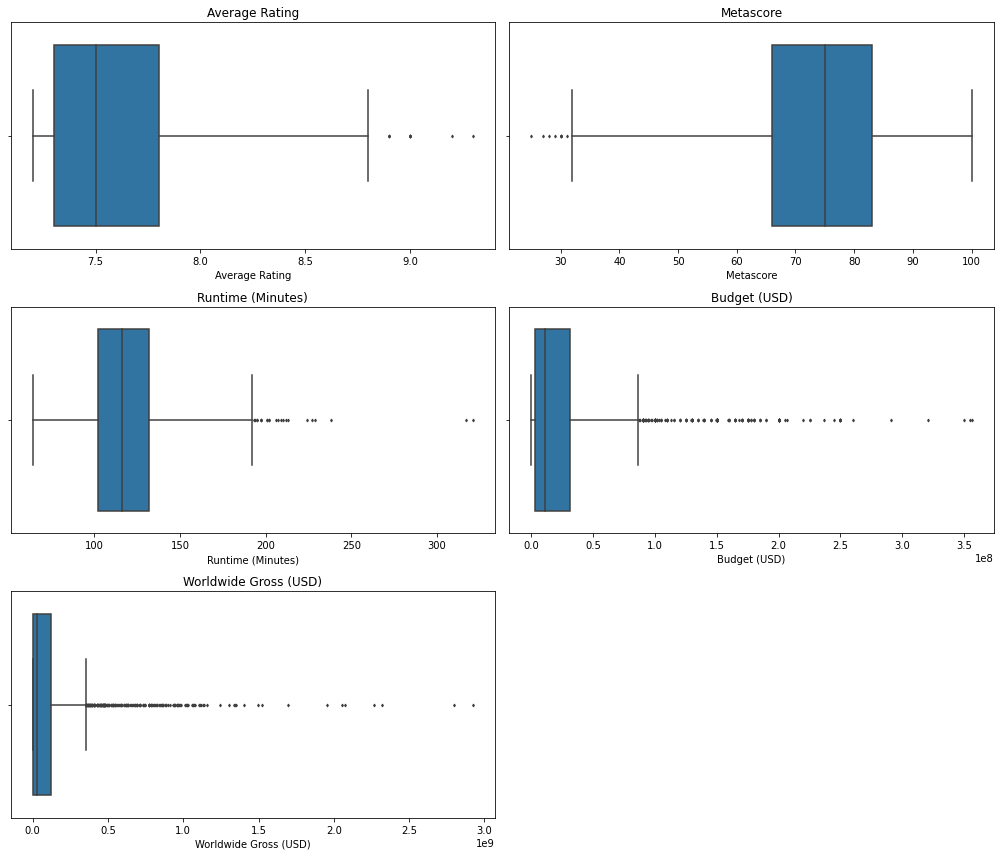

In [268]:
# KIỂM TRA OUTLIERS TRONG CÁC CỘT SỐ BẰNG CÁCH VẼ BIỂU ĐỒ HỘP (BOXPLOT)

numeric_cols = ['Average Rating', 'Metascore', 'Runtime (Minutes)', 'Budget (USD)', 'Worldwide Gross (USD)']
    # Chọn các cột số để kiểm tra outliers
print(f"Numeric features: {numeric_cols}\n")

# tạo 1 lưới biểu đồ để chứa tất cả các boxplot
n = (len(numeric_cols) + 1) // 2  # Cộng 1 để làm tròn lên
fig, axes = plt.subplots(n, 2, figsize=(14, n * 4))
axes = axes.flatten()

# Vẽ boxplot cho từng cột số
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], orient="h", ax=axes[i], whis=2, fliersize=2)
    axes[i].set_title(col)

# Ẩn các ô trống còn lại trong grid nếu số biểu đồ < số khung trục.
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Hiển thị biểu đồ gọn gàng, tránh đè chữ.
plt.tight_layout()
plt.show()

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1926 non-null   object 
 1   Average Rating             1926 non-null   float64
 2   Metascore                  1926 non-null   float64
 3   Budget (USD)               1926 non-null   float64
 4   Worldwide Gross (USD)      1926 non-null   float64
 5   Release_Year               1926 non-null   int64  
 6   Release_Month              1926 non-null   int64  
 7   Runtime (Minutes)          1926 non-null   int64  
 8   Director_grouped           1926 non-null   object 
 9   Writer_grouped             1926 non-null   object 
 10  Country of Origin_grouped  1926 non-null   object 
 11  Languages_grouped          1926 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 195.6+ KB


In [270]:
# HÀM XÁC ĐỊNH NGƯỠNG OUTLIER TRONG CÁC CỘT SỐ

def outlier_thresholds(df, col, q1=0.25, q3=0.75, verbose=False):
    quartile1 = df[col].quantile(q1)   # Lấy Q1 (mặc định là phần tử thứ 25%)
    quartile3 = df[col].quantile(q3)   # Lấy Q3 (mặc định là phần tử thứ 75%)
    iqr = quartile3 - quartile1        # IQR = Q3 - Q1
    
    upper_bound = quartile3 + 1.5 * iqr # Tính ngưỡng trên
    lower_bound = quartile1 - 1.5 * iqr # Tính ngưỡng dưới
         # Các giá trị lớn hơn upper_bound hoặc nhỏ hơn lower_bound được coi là outliers.

    if verbose:
        print(f"Ngưỡng dưới và ngưỡng trên của cột `{col}` là ({lower_bound:.3f}, {upper_bound:.3f}) , và khoảng tứ phân vị (IQR) là: {iqr:.3f}")
        # In ra các ngưỡng và IQR cho cột hiện tại.

    return lower_bound, upper_bound



# SỬ DỤNG outlier_thresholds() ĐỂ ĐẾM SỐ OUTLIERS TRONG CÁC CỘT SỐ
def check_outliers(df, col, q1=0.25, q3=0.75, verbose=False):
    lower_bound, upper_bound = outlier_thresholds(df, col, q1, q3, verbose)
    outliers_count = df[(df[col] > upper_bound) | (df[col] < lower_bound)][col].count()
    
    if verbose:
        print(f"`Cột {col}` chứa {outliers_count} giá trị ngoại lai (outliers).")
    
    outliers_present = bool(outliers_count > 0)
        # Nếu có ít nhất 1 outlier → Trả về True
        # Nếu không có → False
    
    return outliers_present

In [271]:
# KIỂM TRA CÁC CỘT SỐ CÓ OUTLIERS

cols_with_outliers = []
    # Tạo danh sách rỗng để lưu các cột có chứa outliers

# Duyệt qua từng cột số trong danh sách numeric_cols
for col in numeric_cols:
    if check_outliers(df, col, q1=0.2, q3=0.8, verbose=True):
        print()
        cols_with_outliers.append(col)

Ngưỡng dưới và ngưỡng trên của cột `Average Rating` là (6.400, 8.800) , và khoảng tứ phân vị (IQR) là: 0.600
`Cột Average Rating` chứa 10 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Metascore` là (32.500, 116.500) , và khoảng tứ phân vị (IQR) là: 21.000
`Cột Metascore` chứa 10 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Runtime (Minutes)` là (46.000, 190.000) , và khoảng tứ phân vị (IQR) là: 36.000
`Cột Runtime (Minutes)` chứa 27 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Budget (USD)` là (-53750000.000, 96250000.000) , và khoảng tứ phân vị (IQR) là: 37500000.000
`Cột Budget (USD)` chứa 157 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Worldwide Gross (USD)` là (-249638141.500, 422324686.500) , và khoảng tứ phân vị (IQR) là: 167990707.000
`Cột Worldwide Gross (USD)` chứa 164 giá trị ngoại lai (outliers).



In [272]:
def replace_outliers_with_thresholds(df, col):
    lower_bound, upper_bound = outlier_thresholds(df, col, q1=0.2, q3=0.8)
        # Tính toán ngưỡng dưới và trên cho cột hiện tại
    
    df.loc[df[col] < lower_bound, col] = lower_bound
        # Thay thế các giá trị nhỏ hơn ngưỡng dưới bằng ngưỡng dưới
    df.loc[df[col] > upper_bound, col] = upper_bound
        # Thay thế các giá trị lớn hơn ngưỡng trên bằng ngưỡng trên


# THAY THẾ OUTLIERS TRONG CÁC CỘT CÓ OUTLIERS
for col in cols_with_outliers:
    replace_outliers_with_thresholds(df, col)

# KIỂM TRA LẠI CÁC OUTLIERS SAU KHI ĐÃ THAY THẾ
for col in cols_with_outliers:
    check_outliers(df, col, q1=0.2, q3=0.8, verbose=True)
    print()

Ngưỡng dưới và ngưỡng trên của cột `Average Rating` là (6.400, 8.800) , và khoảng tứ phân vị (IQR) là: 0.600
`Cột Average Rating` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Metascore` là (32.500, 116.500) , và khoảng tứ phân vị (IQR) là: 21.000
`Cột Metascore` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Runtime (Minutes)` là (46.000, 190.000) , và khoảng tứ phân vị (IQR) là: 36.000
`Cột Runtime (Minutes)` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Budget (USD)` là (-53750000.000, 96250000.000) , và khoảng tứ phân vị (IQR) là: 37500000.000
`Cột Budget (USD)` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Worldwide Gross (USD)` là (-249638141.500, 422324686.500) , và khoảng tứ phân vị (IQR) là: 167990707.000
`Cột Worldwide Gross (USD)` chứa 0 giá trị ngoại lai (outliers).



# 2. Xác định tầm quan trọng của các biến đầu vào đối với biến mục tiêu Worldwide Gross (USD) bằng mô hình Random Forest.

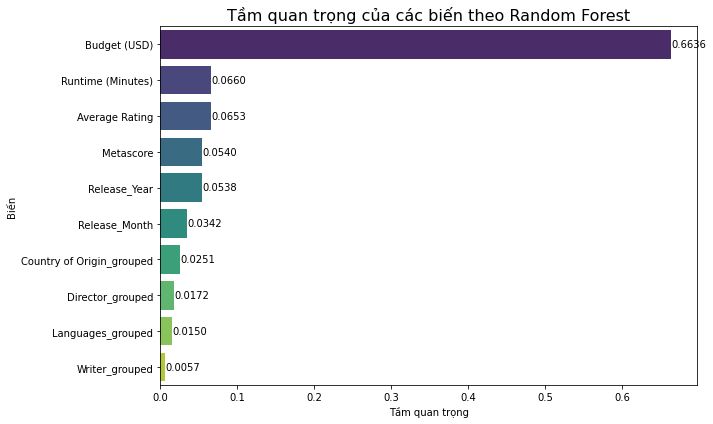

In [273]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

# Đặt biến mục tiêu
target = "Worldwide Gross (USD)"

# Lưu danh sách mapping từ mã số -> tên nhóm (sẽ dùng để vẽ biểu đồ sau này)
category_mappings = {}  # lưu tất cả mappings của từng cột

cat_cols = ['Director_grouped', 'Writer_grouped', 'Languages_grouped', 'Country of Origin_grouped']

for col in cat_cols:
    df[col] = df[col].astype('category')
    category_mappings[col] = dict(enumerate(df[col].cat.categories))  # lưu lại mapping
    df[col] = df[col].cat.codes  # mã hóa thành số để đưa vào mô hình

# Chọn các biến độc lập (X) — loại bỏ cột mục tiêu
X_cols = [col for col in df.columns if col != target]
X = df[X_cols]
y = df[target]

# Chỉ dùng dữ liệu số
X = X.select_dtypes(exclude="object")

# Tách dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Lấy tầm quan trọng của các biến
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)

# Vẽ biểu đồ với nhãn giá trị
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")

# Thêm giá trị trên từng bar
for i, (importance, feature) in enumerate(zip(importance_df["Importance"], importance_df["Feature"])):
    ax.text(importance + 0.0005, i, f"{importance:.4f}", va='center')


plt.title("Tầm quan trọng của các biến theo Random Forest", size=16)
plt.xlabel("Tầm quan trọng")
plt.ylabel("Biến")
plt.tight_layout()
plt.show()

**`Phân tích tầm quan trọng của các biến theo Random Forest`**
1. **Budget** (Ngân sách sản xuất) là biến ảnh hưởng lớn nhất đến doanh thu toàn cầu, chiếm **66.3%** tầm quan trọng. Điều này hợp lý vì ngân sách cao thường đi kèm với chất lượng sản xuất, marketing mạnh, và quy mô phát hành rộng rãi.

2. **Runtime**, **Average Rating**, và **Metascore** có mức độ ảnh hưởng tương đối tương đồng (~6.5%) → cho thấy:
   - Phim dài hơn hoặc được đánh giá cao hơn thường thu hút khán giả nhiều hơn.
   - Các chỉ số đánh giá từ giới chuyên môn (Metascore) và khán giả (Rating) đều đóng vai trò trong việc dự đoán doanh thu.

3. **Release_Year** và **Release_Month** cũng khá quan trọng:
   - Thời điểm phát hành ảnh hưởng lớn đến cơ hội thành công (ví dụ: phát hành mùa lễ hội, cuối tuần, mùa hè...).

4. Các biến định tính đã được mã hóa như:
   - **Country**: 2.5%
   - **Director**, **Languages**, **Writer**: lần lượt là 1.7%, 1.4%, và 0.5%
   → Điều này cho thấy thông tin về quốc gia sản xuất và người đạo diễn có **một phần ảnh hưởng**, nhưng **không phải yếu tố quyết định**.



**`Phân tích các biến có importance >= 0.05:`** Trong đó,
- 4 Biến liên tục:  Budget,  Runtime,  Average rating,  Metascore
- 1 Biến rời rạc: Release_Year 


# 3. Biến liên tục

In [274]:
df[['Budget (USD)', 'Runtime (Minutes)', 'Average Rating', 'Metascore', 'Worldwide Gross (USD)']].describe()

,Budget (USD),Runtime (Minutes),Average Rating,Metascore,Worldwide Gross (USD)
count,1926.0,1926.0,1926.0,1926.0,1926.0
mean,24048441.8,119.0,7.6,74.0,93674812.0
std,29287757.8,23.5,0.4,12.8,131594060.7
min,12.4,64.0,7.2,32.5,19.0
25%,3225000.0,102.0,7.3,66.0,4747928.8
50%,11307214.1,116.0,7.5,75.0,29839267.0
75%,31000000.0,132.0,7.8,83.0,120604751.2
max,96250000.0,190.0,8.8,100.0,422324686.5


**Phân tích:**
- Budget và Worldwide Gross có độ lệch chuẩn rất cao (~29 triệu USD) và (~131.6 triệu USD) cho thấy mức độ phân tán lớn và sự chênh lệch đáng kể giữa các bộ phim về chi phí sản xuất và doanh thu toàn cầu.
- Runtime ổn định, tập trung quanh 2 giờ.
- Average Rating và Metascore cho thấy chất lượng phim tốt, với đánh giá từ khán giả và phê bình khá nhất quán.

## 3.1 Chuẩn hóa dữ liệu bằng phương pháp chuẩn hóa Z-score

In [275]:
from sklearn.preprocessing import StandardScaler

# Xác định các cột liên tục cần chuẩn hóa
cols_to_scale = ['Budget (USD)', 'Runtime (Minutes)', 'Average Rating', 'Metascore']

# Khởi tạo và fit scaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[cols_to_scale])

# Ghi đè các cột đã chuẩn hóa vào df gốc
df[cols_to_scale] = scaled_array

# Kiểm tra 5 dòng đầu tiên sau khi chuẩn hóa
df.head()


c:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\Users\PC\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Title,Average Rating,Metascore,Budget (USD),Worldwide Gross (USD),Release_Year,Release_Month,Runtime (Minutes),Director_grouped,Writer_grouped,Country of Origin_grouped,Languages_grouped
0,The Shawshank Redemption,3.4,0.6,0.0,29332133.0,1994,10,1.0,6,9,9,0
2,The Godfather,3.4,2.0,-0.6,250342198.0,1978,1,2.4,6,9,9,14
7,The Dark Knight,3.4,0.8,2.5,422324686.5,2008,7,1.4,1,9,15,14
8,Schindler's List,3.4,1.6,-0.1,322161245.0,1993,12,3.0,14,9,9,14
9,12 Angry Men,3.4,1.8,-0.8,2945.0,1957,4,-1.0,12,9,9,0


## 3.2 Hình ảnh hóa dữ liệu với các biến liên tục

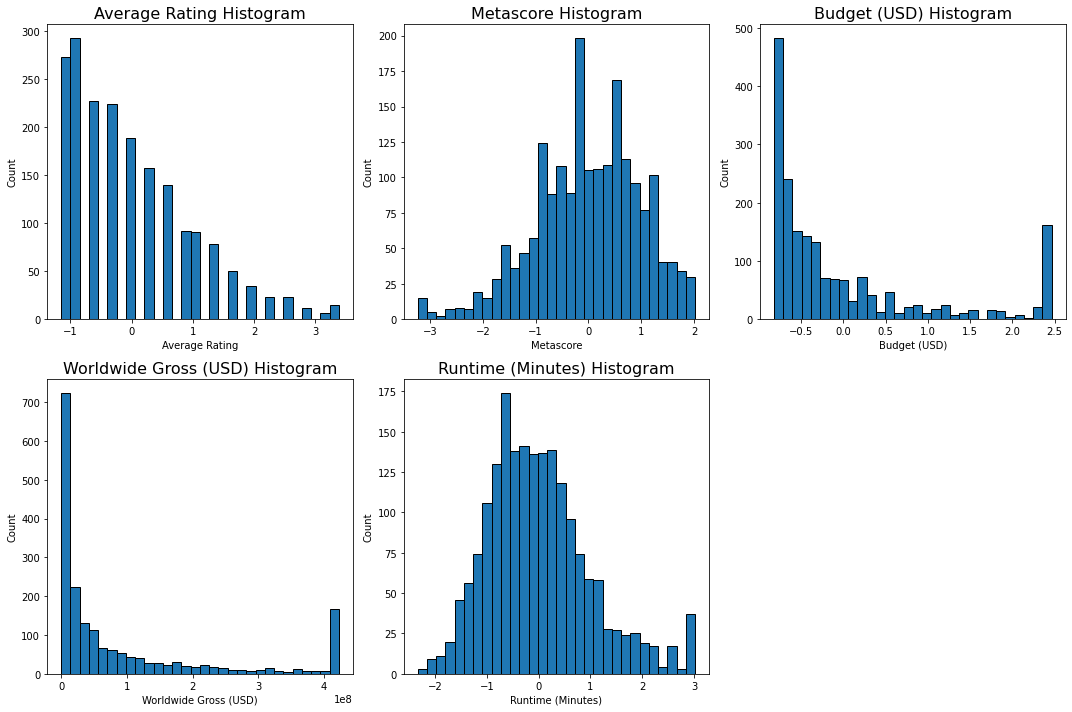

In [276]:
import matplotlib.pyplot as plt

numeric_cols = ['Average Rating', 'Metascore', 
                'Budget (USD)', 'Worldwide Gross (USD)', 'Runtime (Minutes)']

# Tính toán số lượng subplot cần thiết
n = (len(numeric_cols) + 2) // 3
fig, axes = plt.subplots(n, 3, figsize=(15, n * 5))
axes = axes.flatten()

# Vẽ biểu đồ Histogram cho từng cột numeric
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=30, edgecolor='black')  # Sử dụng plt.hist
    axes[i].set_title(f"{col} Histogram", fontsize=16)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Ẩn các subplot thừa
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

**Phân tích:**
- Average Rating: Đạt đỉnh quanh mức 0-1, giảm mạnh khi đánh giá tăng, cho thấy hầu hết phim có đánh giá trung bình thấp.
- Metascore: Tập trung chủ yếu giữa 0-1, với đỉnh đáng kể, cho thấy sự tập trung của các phim có metascore trung bình đến cao.
- Budget (USD): Có phạm vi rộng với đỉnh quanh 0-0.5, và đuôi dài, cho thấy phần lớn phim có ngân sách thấp, với một số phim ngân sách cao.
- Worldwide Gross (USD): Đạt đỉnh gần 0-1 và giảm nhanh, phản ánh phần lớn phim kiếm được ít, với một số phim có doanh thu cao.
- Runtime (Minutes): Tập trung quanh 1-2, với đường cong hình chuông, cho thấy hầu hết phim có thời lượng từ 60-120 phút.

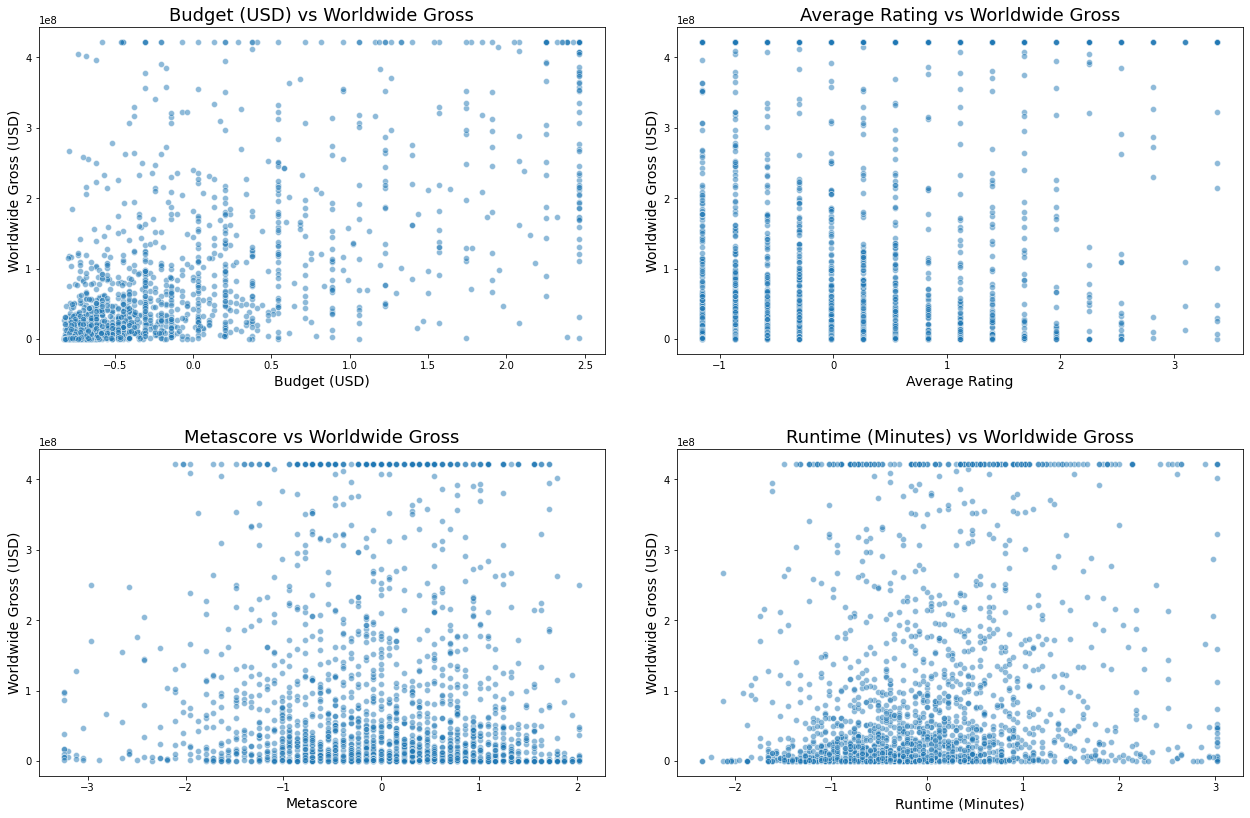

In [277]:
# Danh sách các biến liên tục muốn phân tích
continuous_vars = [
    'Budget (USD)', 'Average Rating', 'Metascore',
    'Runtime (Minutes)'
]

# Thiết lập kích thước figure
plt.figure(figsize=(18, 12))

# Vẽ từng biểu đồ scatter
for i, var in enumerate(continuous_vars, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=df, x=var, y='Worldwide Gross (USD)', alpha=0.5
    )
    plt.title(f'{var} vs Worldwide Gross', fontsize=18)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Worldwide Gross (USD)', fontsize=14)

plt.tight_layout(pad=3.0, w_pad=4.0, h_pad=4.0)
plt.show()

**`Phân tích mối quan hệ giữa các yếu tố và Doanh thu toàn cầu:`**

1. Budget (USD) vs Worldwide Gross (USD)
-  Có xu hướng tăng nhẹ, khi budget cao hơn thì doanh thu toàn cầu cũng có xu hướng cao hơn.
- Tuy nhiên: Dữ liệu bị dày ở phía dưới và có nhiều điểm “nằm ngang” ở mức cao nhất (có thể là ngưỡng trần hoặc bất thường).

2. Average Rating vs Worldwide Gross (USD)
- Không rõ ràng mối quan hệ tuyến tính. Các điểm trải đều, phần lớn nằm dưới.

 3. Metascore vs Worldwide Gross (USD)
- Giống như Average Rating, không có xu hướng tăng/giảm rõ ràng.

 4. Runtime (Minutes) vs Worldwide Gross (USD)
- Phân bố khá ngẫu nhiên, dày đặc ở vùng dưới.
- Không có xu hướng rõ ràng rằng runtime dài hơn thì doanh thu tăng.

---

**`Dựa trên các biểu đồ phân tán và histogram trước đó:`**

- Ngân sách (Budget): Biểu đồ phân tán cho thấy phần lớn phim có ngân sách thấp và doanh thu thấp. Một số phim với ngân sách cao hơn đạt doanh thu lớn, nhưng không có mối quan hệ tuyến tính rõ ràng. Điều này cho thấy ngân sách cao không đảm bảo doanh thu cao, dù có thể tạo điều kiện cho sản xuất phim chất lượng hơn.
- Đánh giá trung bình (Average Rating): Phim có đánh giá từ -1 đến 1 chiếm đa số với doanh thu thấp. Một số phim có đánh giá cao (1-3) đạt doanh thu lớn, nhưng mối liên hệ yếu. Điều này cho thấy đánh giá của khán giả có ảnh hưởng, nhưng không phải yếu tố quyết định chính.
- Metascore: Tương tự, phim có metascore 0-1 thường có doanh thu thấp. Một số ít phim với metascore cao (1-2) đạt doanh thu cao, nhưng không có xu hướng rõ ràng. Điểm số từ giới phê bình có ảnh hưởng nhất định, nhưng không mạnh.
- Thời lượng (Runtime): Phim có thời lượng 60-120 phút chiếm đa số, với doanh thu thấp. Một số phim dài hơn có doanh thu cao, nhưng mối quan hệ không rõ rệt. Thời lượng không phải là yếu tố chính ảnh hưởng đến doanh thu.

## 3.3 Kiểm tra phân phối chuẩn

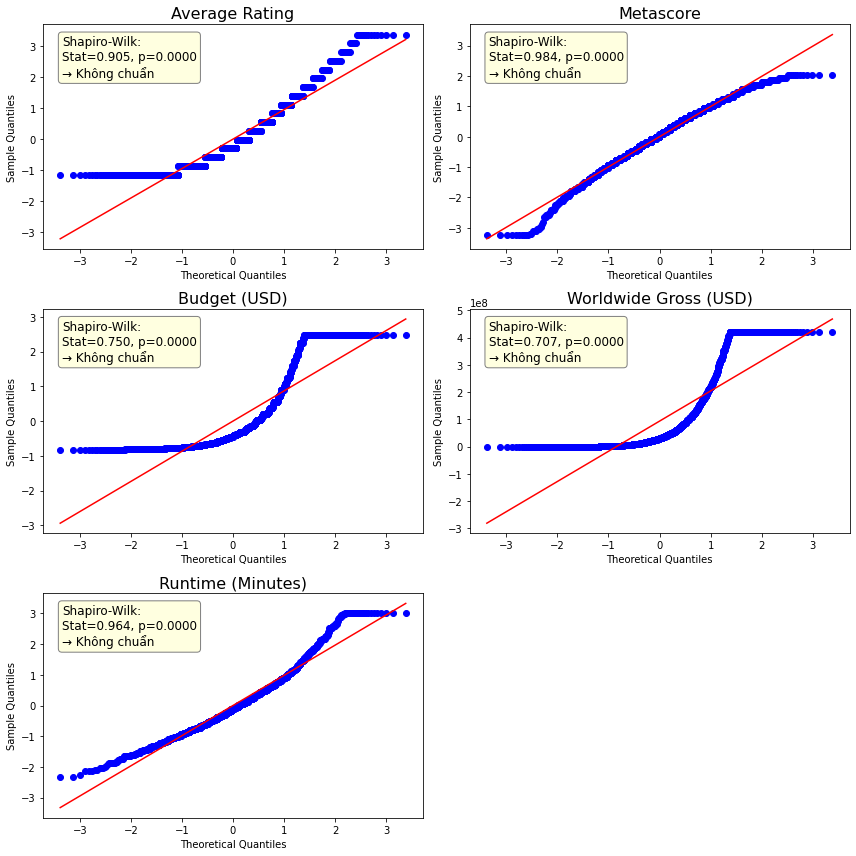

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
import numpy as np


# Tạo lưới 2 cột
n_cols = 2
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  # Flatten để dễ xử lý vòng lặp

for i, col in enumerate(numeric_cols):
    data = df[col].dropna()
    
    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    test_result = "Có thể chuẩn" if p > 0.05 else "Không chuẩn"

    # Vẽ Q-Q Plot
    probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f"{col}", fontsize=16)
    axes[i].set_xlabel("Theoretical Quantiles")
    axes[i].set_ylabel("Sample Quantiles")
    
    # Ghi kết quả kiểm định lên biểu đồ
    axes[i].text(0.05, 0.95, 
                 f"Shapiro-Wilk:\nStat={stat:.3f}, p={p:.4f}\n→ {test_result}", 
                 transform=axes[i].transAxes,
                 fontsize=12, 
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="gray", lw=1))

# Ẩn các ô thừa nếu số biến không chia hết cho 2
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Sau khi kiểm tra phân phối chuẩn bằng kiểm định Shapiro-Wilk và Q-Q plot, tất cả các biến số đều không tuân theo phân phối chuẩn, ngay cả sau khi loại bỏ outliers. Do đó, các phương pháp thống kê phi tham số sẽ được sử dụng trong phân tích tiếp theo nhằm đảm bảo tính chính xác và phù hợp với bản chất dữ liệu.


## 3.4 Tương quan Spearman

Tương quan Spearman với 'Worldwide Gross (USD)':
Budget (USD)         0.8
Runtime (Minutes)    0.3
Average Rating       0.1
Metascore           -0.1
Name: Worldwide Gross (USD), dtype: float64


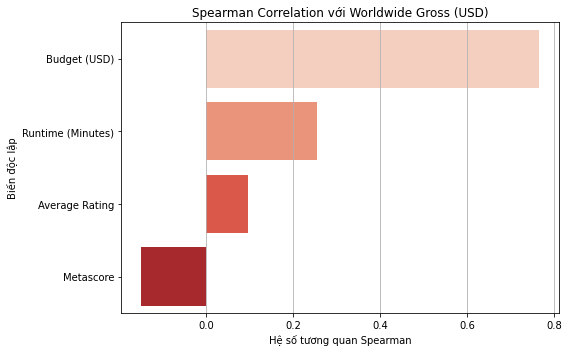

In [279]:

# Tính tương quan Spearman giữa các biến độc lập và Worldwide Gross
spearman_corr = df[numeric_cols].corr(method='spearman')

# Lấy hệ số tương quan với biến mục tiêu
gross_corr = spearman_corr['Worldwide Gross (USD)'].drop('Worldwide Gross (USD)').sort_values(ascending=False)

# In kết quả
print("Tương quan Spearman với 'Worldwide Gross (USD)':")
print(gross_corr.round(3))

# Vẽ biểu đồ tương quan
plt.figure(figsize=(8, 5))
sns.barplot(x=gross_corr.values, y=gross_corr.index, palette="Reds")  # <--- palette hợp lệ
plt.title("Spearman Correlation với Worldwide Gross (USD)")
plt.xlabel("Hệ số tương quan Spearman")
plt.ylabel("Biến độc lập")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()



**`Phân tích Tương quan Spearman với Worldwide Gross (USD)`**
- **Budget (USD)** có tương quan mạnh nhất (**0.8**) → Ngân sách lớn thường kéo theo doanh thu cao.
- **Runtime (0.3)** có tương quan trung bình → Phim mới hơn, dài hơn có thể có lợi thế nhẹ.
- **Average Rating (0.1)** tương quan yếu → Đánh giá cao không đảm bảo doanh thu cao.
- **Metascore (-0.1)** hầu như không có ảnh hưởng rõ rệt đến doanh thu.


In [280]:
from scipy.stats import spearmanr
import pandas as pd

results = {}

for col in numeric_cols:
    if col != 'Worldwide Gross (USD)':
        rho, pval = spearmanr(df[col], df['Worldwide Gross (USD)'])
        results[col] = {'rho': rho, 'pval': pval}

# Tạo DataFrame kết quả
result_df = pd.DataFrame(results).T

# Làm tròn pval 6 chữ số
result_df['pval'] = result_df['pval'].apply(lambda x: f"{x:.18f}")

# Sắp xếp theo độ mạnh tương quan (rho) — dùng để sắp xếp thôi
result_df = result_df.sort_values(by='pval', ascending=True)

# In chỉ cột pval
print("P-value Spearman giữa các biến độc lập và 'Worldwide Gross (USD)':")
print(result_df[['pval']])


P-value Spearman giữa các biến độc lập và 'Worldwide Gross (USD)':
                                   pval
Budget (USD)       0.000000000000000000
Runtime (Minutes)  0.000000000000000000
Metascore          0.000000000041817865
Average Rating     0.000024030690516508


`Phân tích P-value Spearman: Mối tương quan với 'Worldwide Gross (USD)'`

- **Runtime (Minutes)**: Rất có ý nghĩa thống kê. Thời lượng phim có thể ảnh hưởng đến sự quan tâm của khán giả và doanh thu.
- **Budget (USD)**: Rất có ý nghĩa thống kê. Ngân sách là yếu tố rất quan trọng.
- **Metascore**: Rất có ý nghĩa thống kê. Phim được đánh giá cao sẽ thu hút nhiều khán giả hơn.
- **Average Rating**: Có ý nghĩa thống kê. 


## 3.5 Kiểm tra đa cộng tuyến bằng VIF

In [281]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm


all_vars = [
    'Worldwide Gross (USD)', 
    'Budget (USD)', 'Runtime (Minutes)', 
    'Average Rating', 'Metascore'
]

df_model = df[all_vars].dropna()

# Giữ lại chỉ các biến liên tục (số thực, số nguyên)
X = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['Worldwide Gross (USD)'])

# Thêm cột hằng số (constant) để tính VIF
X_const = add_constant(X)

# Tính VIF cho mỗi biến
vif_data = pd.DataFrame()
vif_data['Variable'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# In kết quả VIF
print("\nVIF (Variance Inflation Factor) của các biến:")
print(vif_data.round(2))



VIF (Variance Inflation Factor) của các biến:
            Variable  VIF
0              const  1.0
1       Budget (USD)  1.1
2  Runtime (Minutes)  1.2
3     Average Rating  1.2
4          Metascore  1.2


`Phân tích VIF (Variance Inflation Factor) của các biến liên tục`

- **Không có vấn đề đa cộng tuyến nghiêm trọng**: Tất cả các biến độc lập đều có VIF < 5, cho thấy chúng không bị ảnh hưởng lẫn nhau đáng kể.
- **VIF cao ở `const` là bình thường**, không phải là biến cần kiểm soát.
- Do đó, mô hình hồi quy tuyến tính có thể sử dụng các biến này một cách ổn định mà không lo bị sai lệch do đa cộng tuyến.

---

`Tóm lại:`

Mô hình hồi quy hiện tại **an toàn về mặt đa cộng tuyến**, giúp cải thiện độ tin cậy của các hệ số và giảm thiểu rủi ro **overfitting** khi huấn luyện mô hình.


## 3.6 Mô hình GLM 

In [282]:
import statsmodels.api as sm

df_selected = df[['Worldwide Gross (USD)', 'Budget (USD)', 'Runtime (Minutes)', 
                  'Average Rating', 'Metascore']].dropna()

# Tách X và y
X = df_selected[['Budget (USD)', 'Runtime (Minutes)', 'Average Rating', 'Metascore']]
y = df_selected['Worldwide Gross (USD)']

# Thêm hệ số chệch (constant)
X_const = sm.add_constant(X)

# Xây dựng mô hình GLM
glm_model = sm.GLM(y, X_const, family=sm.families.Gaussian()).fit()

# Hiển thị kết quả
glm_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     Worldwide Gross (USD)   No. Observations:                 1926
Model:                               GLM   Df Residuals:                     1921
Model Family:                   Gaussian   Df Model:                            4
Link Function:                  identity   Scale:                      6.0784e+15
Method:                             IRLS   Log-Likelihood:                -37729.
Date:                   Sat, 03 May 2025   Deviance:                   1.1677e+19
Time:                           05:17:57   Pearson chi2:                 1.17e+19
No. Iterations:                        3   Pseudo R-squ. (CS):             0.8428
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9.367e+07   1.78e+06     52.730      0.000    9.02e+07    9.72e+07
Budget (USD)        1.06e+08    1.9e+06     55.867      0.000    1.02e+08     1.1e+08
Runtime (Minutes) -1.157e+07   1.92e+06     -6.031      0.000   -1.53e+07   -7.81e+06
Average Rating     2.409e+07   1.97e+06     12.243      0.000    2.02e+07    2.79e+07
Metascore          2.559e+06   1.95e+06      1.314      0.189   -1.26e+06    6.38e+06
=====================================================================================
"""

**`Tổng quan mô hình`**
- Số quan sát (No. Observations): 1926 phim.
- Mô hình sử dụng: Hồi quy tuyến tính tổng quát (GLM) với phân phối Gaussian và link function = identity (tức là dạng tuyến tính thông thường).
- Deviance và Pearson chi2: khoảng 1.17e+19, thể hiện sai số còn lại trong mô hình.
- Pseudo R-squared (Cox-Snell): 0.8428 → mô hình giải thích khoảng 84.28% phương sai của biến phụ thuộc (Worldwide Gross), cho thấy mô hình khá tốt.

**`Phân tích từng biến:`**


**1) Budget (USD)**
- ngân sách là yếu tố có ảnh hưởng mạnh nhất đến doanh thu toàn cầu, với hệ số hồi quy là 106 triệu USD, nghĩa là mỗi USD tăng thêm trong ngân sách làm tăng trung bình 106 USD doanh thu. 
- Biến này có ý nghĩa thống kê rất cao (p < 0.001), khẳng định vai trò then chốt của chi phí đầu tư trong thành công thương mại của phim.


**2) Runtime (Minutes)**
- Thời lượng phim (Runtime) lại cho thấy mối quan hệ tiêu cực với doanh thu, với hệ số khoảng -11.57 triệu USD cho mỗi phút tăng thêm. 
    =>Điều này gợi ý rằng phim có thời lượng quá dài có thể làm giảm số suất chiếu và sự hấp dẫn đối với một bộ phận khán giả, từ đó ảnh hưởng đến doanh thu. 
- Kết quả này cũng có ý nghĩa thống kê (p < 0.001).

**3) Average Rating**
- Đánh giá trung bình (Average Rating) cũng là yếu tố có tác động tích cực và đáng kể, với mỗi điểm tăng trong đánh giá có thể giúp doanh thu tăng khoảng 24.09 triệu USD, cho thấy mối liên hệ chặt chẽ giữa chất lượng nội dung và mức độ thu hút khán giả. 
- Biến này cũng có ý nghĩa thống kê rất cao (p < 0.001).


**4) Metascore**
- Cuối cùng, biến Metascore dù có hệ số dương (2.56 triệu USD) nhưng không có ý nghĩa thống kê (p = 0.189), cho thấy không có đủ bằng chứng để kết luận rằng Metascore ảnh hưởng rõ rệt đến doanh thu toàn cầu trong mô hình này.

---
**`Kết luận:`**
- Budget là yếu tố có ảnh hưởng lớn nhất và rất có ý nghĩa đến doanh thu toàn cầu.
- Average Rating cũng có ảnh hưởng tích cực và mạnh.
- Runtime có ảnh hưởng ngược chiều — phim dài hơn thường thu ít hơn, có thể do ảnh hưởng đến khả năng tiếp cận khán giả đại chúng.
- Metascore không có ảnh hưởng đáng kể trong mô hình này.



# 4. Biến rời rạc 

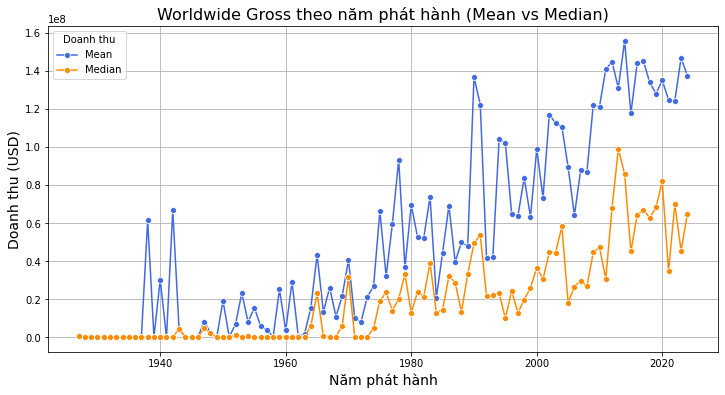

In [284]:
# Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tính doanh thu trung bình và trung vị theo năm
yearly_gross = df.groupby('Release_Year')['Worldwide Gross (USD)'].agg(['mean', 'median', 'count']).reset_index()

# 2. Vẽ biểu đồ đường doanh thu trung bình và trung vị theo năm
plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_gross, x='Release_Year', y='mean', marker='o', color='royalblue', label='Mean')
sns.lineplot(data=yearly_gross, x='Release_Year', y='median', marker='o', color='darkorange', label='Median')
plt.title('Worldwide Gross theo năm phát hành (Mean vs Median)', fontsize=16)
plt.xlabel('Năm phát hành', fontsize=14)
plt.ylabel('Doanh thu (USD)', fontsize=14)
plt.legend(title='Doanh thu', loc='upper left')
plt.grid(True)
plt.show()



**Phân tích:** 

1) Xu hướng tăng rõ rệt theo thời gian:
- Cả giá trị mean lẫn median đều có xu hướng tăng dần từ năm 1930 tới 2020.
- Điều này cho thấy rằng doanh thu toàn cầu của phim ngày càng cao hơn theo từng thời kỳ.

2) Khoảng cách giữa mean và median:
- Mean > Median xuyên suốt tất cả các năm.
- Khoảng cách này càng lớn từ thập niên 1980 trở đi.

➔ Giải thích: Có sự ảnh hưởng mạnh của các phim có doanh thu cực kỳ cao ("outlier" doanh thu cao), làm mean bị kéo lên so với median.

3) Các giai đoạn đáng chú ý:
- Từ khoảng năm 1980 trở đi, doanh thu trung bình bắt đầu tăng mạnh hơn.
- Đặc biệt từ 1995 đến nay, cả mean và median cùng tăng vọt ➔ có thể liên quan đến:
        - Sự phát triển mạnh mẽ của ngành công nghiệp điện ảnh toàn cầu.
        - Sự bùng nổ của các hãng phim lớn (Disney, Marvel, Warner Bros, v.v).
        - Hệ thống phân phối phim toàn cầu mở rộng (ra rạp nhiều quốc gia).
        - Công nghệ CGI và marketing toàn cầu cũng góp phần làm tăng doanh thu.

**Kết luận**
- Năm phát hành (Release Year) là một trong những yếu tố ảnh hưởng đến doanh thu.
- Những phim phát hành trong thời hiện đại có xu hướng doanh thu cao hơn phim cổ điển. Do xu thế ngành, các yếu tố công nghệ, quy mô phát hành quốc tế, mức độ đầu tư (budget) cũng tăng theo thời gian.
- Sự chênh lệch giữa mean và median phản ánh sự chi phối của một số phim bom tấn cực lớn.

---
# 5. TỔNG KẾT:
- Phân tích cho thấy ngân sách sản xuất (Budget) là yếu tố có ảnh hưởng mạnh nhất đến doanh thu toàn cầu của phim, chiếm 66.3% tầm quan trọng theo mô hình Random Forest và có hệ số rất cao trong mô hình hồi quy tuyến tính. 

    => Điều này khẳng định rằng đầu tư tài chính là yếu tố nền tảng giúp nâng cao chất lượng sản xuất, tăng cường chiến dịch quảng bá và mở rộng quy mô phát hành.

- Các yếu tố như Runtime, Average Rating, và Metascore tuy có mức độ ảnh hưởng thấp hơn (~6.5%) nhưng vẫn giữ vai trò quan trọng. Phim dài hơn hoặc được đánh giá cao (từ khán giả hoặc giới phê bình) có xu hướng đạt doanh thu tốt hơn, dù mối quan hệ không phải lúc nào cũng tuyến tính rõ ràng. Trong đó, Average Rating có ảnh hưởng tích cực và đáng kể đến doanh thu, trong khi Runtime có thể ảnh hưởng ngược chiều nếu phim quá dài.

- Thời điểm phát hành (Release Year) cũng cho thấy ảnh hưởng rõ rệt đến doanh thu, đặc biệt các phim phát hành từ năm 1995 trở đi có xu hướng đạt doanh thu cao hơn đáng kể, phản ánh sự phát triển của công nghiệp điện ảnh toàn cầu và xu hướng thị trường.

- Ngoài ra, một số biến định tính như quốc gia sản xuất (Country), đạo diễn (Director), và ngôn ngữ (Languages) có ảnh hưởng nhất định nhưng không phải là yếu tố quyết định. Điều này cho thấy chất lượng nội dung và chiến lược phát hành có vai trò nổi bật hơn danh tiếng cá nhân hay yếu tố địa lý.

---
# 6. ĐỀ XUẤT:
- Tăng cường đầu tư vào ngân sách sản xuất và marketing: Vì ngân sách có tác động lớn nhất đến doanh thu, các nhà sản xuất nên phân bổ ngân sách hợp lý để đảm bảo chất lượng kỹ thuật, nội dung, và quảng bá tốt hơn.

- Duy trì thời lượng phim hợp lý (~90–120 phút): Thời lượng phim nên đủ để truyền tải nội dung một cách hiệu quả mà không gây mệt mỏi cho khán giả, đặc biệt là với các phim thương mại đại chúng.

- Tối ưu hóa thời điểm phát hành: Nên phát hành phim vào các thời điểm cao điểm như mùa hè, lễ Tết, cuối tuần dài ngày, nhằm tối đa hóa khả năng tiếp cận khán giả.

- Tập trung vào chất lượng nội dung để nâng cao Average Rating: Đánh giá từ khán giả có mối liên hệ tích cực với doanh thu, nên việc đầu tư vào kịch bản, diễn xuất và trải nghiệm xem phim sẽ mang lại hiệu quả cao về mặt tài chính.

- Phân tích thị trường theo thời gian và xu thế hiện đại: Các nhà sản xuất nên tận dụng các công nghệ mới, nền tảng phân phối số và marketing toàn cầu để thích nghi với xu hướng tăng trưởng doanh thu của điện ảnh hiện đại.